In [2]:
import sys
sys.path.append('..')

In [32]:
from models import ReLog, Lambda
from torch import nn
import torch
import numpy as np
import math

# Kaiming initialization (PyTorch's default)

In [4]:
x = torch.randn(3, 10)

In [5]:
x.mean(), x.std()

(tensor(-0.0660), tensor(0.9923))

In [6]:
y = x
print(y.std(axis=0).mean().item())
for _ in range(20):
    block = nn.Sequential(nn.Linear(10, 10), ReLog(10))
    y = block(y)
    print(y.std(axis=0).mean().item())

1.0105431079864502
0.3894420266151428
0.19614726305007935
0.13885560631752014
0.11382758617401123
0.0655001848936081
0.034461379051208496
0.009228548966348171
0.0036919035483151674
0.0016439638566225767
0.0009394347434863448
0.0009610024280846119
0.0011591394431889057
0.00046461456804536283
0.00012937680003233254
0.00016299441631417722
5.110858637635829e-06
5.339526524039684e-06
5.148221134732012e-06
7.528261448896956e-06
5.363266154745361e-06


In [7]:
y

tensor([[0.0000, 0.0000, 0.0000, 0.1448, 0.0000, 0.6572, 0.0000, 0.4458, 0.3549,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.1448, 0.0000, 0.6572, 0.0000, 0.4458, 0.3550,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.1448, 0.0000, 0.6572, 0.0000, 0.4458, 0.3549,
         0.0000]], grad_fn=<AddBackward0>)

We can see clearly that standard deviation of neurons gradually goes down to zero and the activation of some neurons is also zero. This makes training super hard.

# Measure variance empirically

In [8]:
from torch.nn import functional as F
relog = lambda x, n: torch.log(F.relu(x) + 1/n) / math.log(n) + 1

In [9]:
std_x = np.linspace(1, 5, 100)

In [10]:
ys = [relog(torch.randn(100)*s, 10) for s in std_x]

In [11]:
std_y = np.array([y.std() for y in ys])

In [12]:
math.sqrt(1/std_y[0])

1.3885791724136964

In [13]:
ey = np.array([y.mean() for y in ys])

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

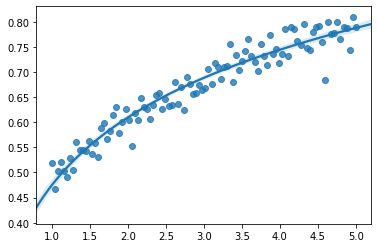

In [15]:
_ = sns.regplot(std_x, std_y, logx=True)

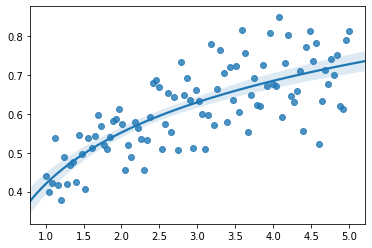

In [16]:
_ = sns.regplot(std_x, ey, logx=True)

In [17]:
np.poly1d(np.polyfit(np.log(std_x), ey, 1))

poly1d([0.19215506, 0.41914846])

In [18]:
math.sqrt(1 / (0.26271359 + 0.19558362))

1.4771561035924354

# Modified Kaiming initialization

In [35]:
x = torch.randn(100, 10)

In [36]:
class PreRelogLinear(nn.Linear):

    def __init__(self, *args, **kwargs):
        assert kwargs.get('bias', True), 'You need bias for ReLog'
        super(PreRelogLinear, self).__init__(*args, **kwargs)
        
    def reset_parameters(self):
        # not sure why this one works...
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.normal_(self.weight, mean=0.5*bound, std=bound)
        nn.init.constant_(self.bias, -0.05)

In [43]:
# y = x
# # print(y.std(axis=0).mean().item())
# for _ in range(20):
#     block = nn.Sequential(PreRelogLinear(10, 10), ReLog(10))
#     y = block(y)
#     stds = y.std(axis=0)
#     print(stds.mean().item(), stds.std().item())
#     print(y[:3])    

In [60]:
modules2 = []
for i in range(5):
    modules2 += [
        PreRelogLinear(10, 10),
        ReLog(10),
        Lambda(lambda x: x-0.5)
    ]
net2 = nn.Sequential(*modules2)

In [61]:
y2 = net2(x)

In [62]:
y2[:3]

tensor([[-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000]], grad_fn=<SliceBackward>)

In [63]:
y2.std(axis=0)

tensor([0.0493, 0.0826, 0.1220, 0.0694, 0.0000, 0.0000, 0.0157, 0.0000, 0.0953,
        0.1042], grad_fn=<StdBackward1>)

In [55]:
y2.mean(axis=0)

tensor([-0.4026, -0.3771, -0.4199, -0.4106, -0.4008, -0.4311, -0.4289, -0.4458,
        -0.4238, -0.3609], grad_fn=<MeanBackward1>)

# Test my models

In [27]:
from models import VGG
import torch

In [28]:
net = VGG()

In [29]:
x = torch.randn(1000, 3, 32, 32)

In [30]:
%%time
y = net(x)

CPU times: user 7.27 s, sys: 925 ms, total: 8.19 s
Wall time: 13.9 s


In [31]:
y.mean(), y.std()

AttributeError: 'tuple' object has no attribute 'mean'

In [ ]:
y